In [266]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import time

Import local file to test on. If it does not exist, get it:

`User:~$ wget s3-ap-southeast-2.amazonaws.com/imos-data/IMOS/SOOP/SOOP-BA/VLMJ_Investigator/Investigator_20160412-20160414/IMOS_SOOP-BA_AE_20160412T031347Z_VLMJ_FV02_Investigator-EK60-18_END-20160414T043251Z_C-20210622T061448Z.nc`

In [2]:
filename = "IMOS_SOOP-BA_AE_20160412T031347Z_VLMJ_FV02_Investigator-EK60-18_END-20160414T043251Z_C-20210622T061448Z.nc"
ds = xr.open_dataset(filename)

Here is what those data look like:

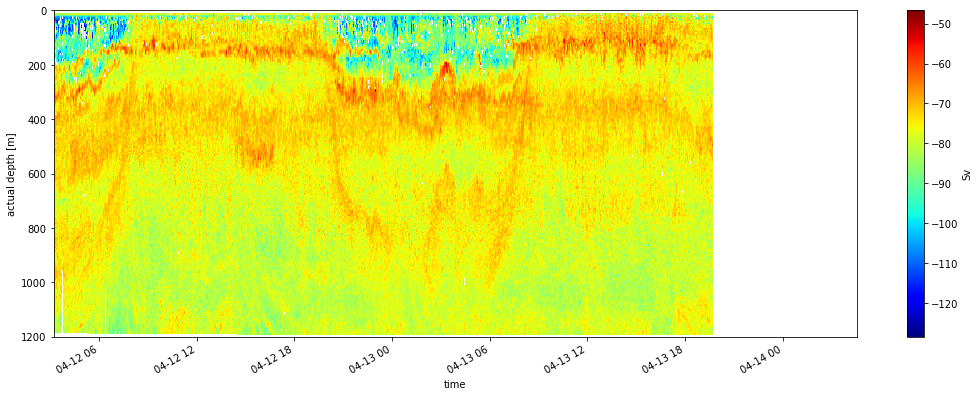

In [166]:
# plot sv data with 10log_10 scaling
fig = (10*np.log10(ds.Sv)).plot(x='TIME', size=6, aspect=3, cmap="jet")
# invert y axis so that depth increases downwards
plt.gca().invert_yaxis()

# Proud, 2015 algorithm implementation

Note: this code ONLY attempts the initial masking of potential SSLs through comparison to every combination of adjacent window means. No further processing is attempted.

In [259]:
def find_layer(xr_data):
    '''
    find_layer: implementation of the Proud, 2015 sound scattering layer (SSL) identification algorithm.
                see DOI:10.1111/2041-210X.12396
                In brief, each element of the column vector is designated an SSL if there exists an 
                adjacent window both above AND below the element, of any size greater than 2, for which
                the value of the element is greater than the mean over the window.
                Our implementation attempts to leverage xarray's .rolling() and .construct() methods to 
                create the desired windows, looking once at the means of every window size above and below
                each element, and designating the element an SSL if the element is greater than at least
                one of each.
    Input:
        xr_data (xarray.DataArray, 1 dimensional) - one column of data (i.e. one ping)
    Output:
        mask (numpy.ndarray) - boolean array, corresponding in size to the xr_data input
                
    Ocean Hackweek, Aug 3-6 2021
    skygering@gmail.com
    benjamingetraer@gmail.com
    '''
    n_val = len(xr_data.data) # number of values in the data vector
    
    def window_mask(xr_data, a_b):
        '''
        window_mask: expands xr_data vector into auxillary "window" dimension to create a square matrix,
        flips the matrix in order to take a cumulative mean corresponding to each possible window above
        or below a certain value indexed appropriately.
        Inputs: xr_data (xarray.DataArray, 1 dimensional) 
                a_b (string) "a" for above, "b" for below. Indexing is different in order to get the final
                        mask vector to correspond to the original indexing of the data.
        Output: mean_mask (numpy.ndarray) - boolean array. TRUE for an indexed element greater than any 
                        corresponding window means.
        '''
        # construct auxillary window dimension
        window_matrix = xr_data.rolling({xr_data.dims[0]:n_val}).construct("window_dim")
        # flip the matrix and execute rolling mean
        flipped_window = np.flip(window_matrix, axis=1)
        # skip nan data to allow it in the dataset!
        mean_window = flipped_window.cumsum("window_dim",skipna=True).data/range(1, len(flipped_window[0]) + 1)
        # reconstruct required lower triangular matrix by replacing nan
        mean_window[np.triu_indices(mean_window.shape[0], 1)] = np.nan
        # drop means that have less than two values in the window
        mean_window = mean_window[:,1:]
        
        # The indexing here compares each element of xr_data to the row of windowed means associated with
        # it. All of the flipping and such creates a convoluted indexing. Try drawing out all of the 
        # matrices to see how it fits together.
        
        # masking for the means above the values
        if a_b=='a':
            mean_mask = np.any([mean_window[i-1] < xr_data.data[i] for i in range(len(flipped_window))], axis=1)
        # masking for the means below the values
        else:
            mean_mask = np.zeros(len(flipped_window), dtype=bool)
            for i in range(len(flipped_window)-2):
                mean_mask[i] = np.any([mean_window[i-1] < xr_data.data[i] ], axis=1)
            mean_mask = np.flip(mean_mask)
        
        # reset the top and bottom rows to false, as i=-1 indexing here may have messed them up
        mean_mask[0] = False; mean_mask[-1] = False
        return mean_mask
    
    # check means for windows above and below each value
    above_mask = window_mask(xr_data,'a')
    below_mask = window_mask(np.flip(xr_data),'b')
    
    # return a single mask, where TRUE elements must pass both masks
    return above_mask & below_mask

Conduct tests with known/simple vectors to test behaviour and insert print statements

In [260]:
# Tests with 1-10
a = xr.DataArray(np.arange(10), dims=("dim1"))
find_layer(a)

array([False, False, False, False, False, False, False, False, False,
       False])

In [261]:
# Tests with 1-10
v = xr.DataArray([3,2,56,43,33,10,5,5,11,8,6], dims=("TIME"))
find_layer(v)

array([False, False,  True,  True,  True, False, False, False,  True,
       False, False])

# Test on echogram data

In [337]:
# actual echogram data
n = 100 # number of columns to test
test_columns = xr.DataArray(ds.Sv,dims=("TIME","DEPTH"))[:n, :] # the columns we will mask

# find mask columns
masked_columns = copy.deepcopy(test_columns) 
start_time = time.time() # start timer
for t in range(len(masked_columns.data[:n, :])):
    masked_columns.data[t] = find_layer(ds.Sv.isel(TIME=t))

# print timer
elapsed = time.time() - start_time
print(elapsed)

1.3508210182189941


Performance tests: approximately 0.0135 seconds per column, linear

|no. rows    |no. columns|time (s)   |
| -----------|-----------|--------|
| 240        | 10        |   0.14     |
|            | 25        |   0.35    |     
|            | 50        |   0.67     | 
|            | 100       |   1.35    | 
|            | 200       |   2.75    | 
|            | 500       |   6.75| 
|            | 1000      |   13.35     | 
|            | 2000      |   27.05     | 
|            | 6569      |   88.90    | 

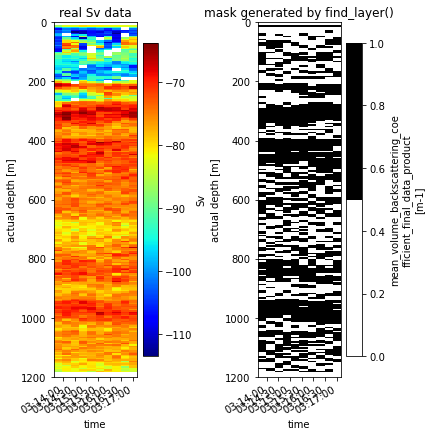

In [331]:
# Plotting
fig, axes = plt.subplots(1,2,figsize=(6,6))


cmap = mpl.colors.ListedColormap(['w', 'k'])
# plot data with 10log_10 scaling
fig = (10*np.log10(test_columns)).plot(x='TIME', cmap="jet",ax=axes[0])
fig = (masked_columns).plot(x='TIME', cmap=cmap,ax=axes[1])

plt.tight_layout()

# invert y axis so that depth increases downwards
axes[0].invert_yaxis()
axes[1].invert_yaxis()

# titles
axes[0].set_title("real Sv data");
axes[1].set_title("mask generated by find_layer()");